# 1D QUBIC
### JCH - Feb. 2025

This notebook and associated library `qubic/lib/Q1d.py` are investigating a 1 dimensional version of QUBIC, where the synthesized beam and sky are restricted to 1D. Although useless for practical use, this is atool that will allow us to investigate a number of interesting issues related to sky reconstruction as one can brute force inverse the matrices in that case.

We can for instance check for specifiec issues such as:
- reconstructed sky pixellization w.r.t. actual smooth sky
- comparison between and imager and B.I.
- study of the effect of the ripples in the synthesized beam and actual shape of the synthesized beam peaks, while our reconstruction algorithms rely for now on the so-called "Gaussian Peak Approxmmation" (GPA) in which the synthesized beam is simplified at reconstructed stage by a series of gaussians.
- alternative reconstruction techniques to be investigated (such as the synthesized beam factorization proposed in 2024 by Victor Chabirand)
- other things for sure...


## Mandatory imports
`qubic/lib/Q1d.py` is the library that is used by this notebook.


In [25]:
%matplotlib ipympl


import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
from importlib import reload    

from qubic.lib import Q1d as q1d 

sz = 10.
plt.rc('figure',figsize=(sz,sz/1.618))
plt.rc('font',size=10)
plt.rc('image', cmap='jet')

## Investigation of the various Instruments models
Currently, three instrument models are implemented:
- a perfect imager, with a perfect gaussian as the synthesized beam
- a theoretical bolometric interferometer where the synthesized beam (for TOD fabrication) is modelled as a theoretcal B.I. in 1D, taken from Eq. 2.7 from QUBIC II paper (https://arxiv.org/pdf/2010.15119).
- a BI approximmated by the Gaussian Peak approximmation.

The various parameters are transmitted through the `params` dictionary for which a default version can be found in the `qubic/lib/Q1d.py` and then modified in the current notebook. 

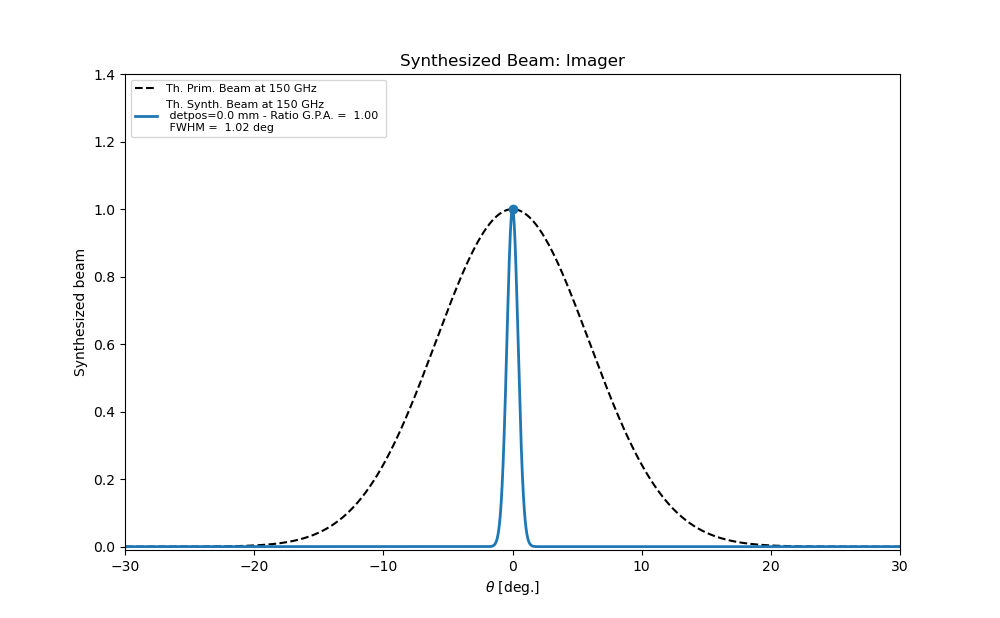

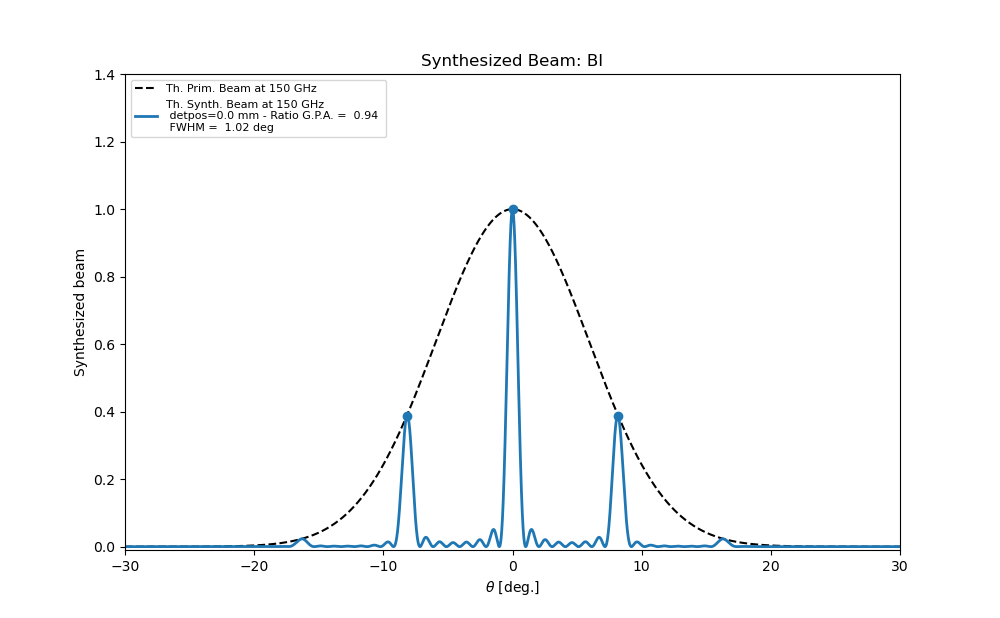

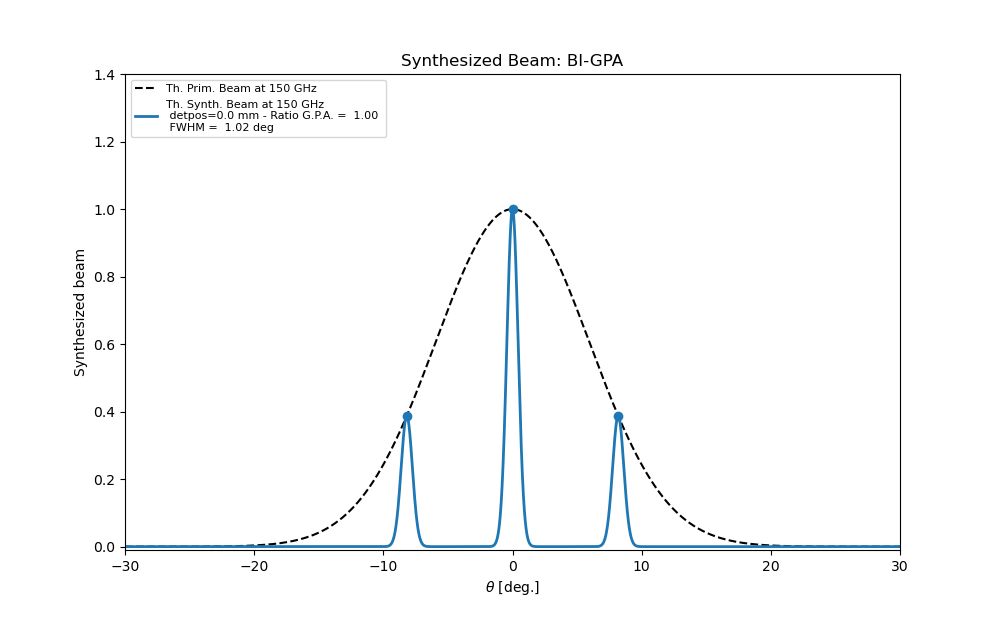

In [26]:
reload(q1d)

params = q1d.params.copy()

#### Show possible synthesized beam
th = np.linspace(-params['minmaxtheta'], params['minmaxtheta'], params['ntheta'])    # theta values in degrees for synthesized beam
params_temp = params.copy()
params_temp['plot_sb'] = True

# Imager
params_temp['instrument_type'] = 'Imager'
_ = q1d.prepare_synthesized_beam(th, params_temp)

# BI   
params_temp['instrument_type'] = 'BI'
_ = q1d.prepare_synthesized_beam(th, params_temp)

# BI-GPA
params_temp['instrument_type'] = 'BI-GPA'
_ = q1d.prepare_synthesized_beam(th, params_temp)

## Simulation subtle effects:

Below we perform the TOD creation and recnstruction in a single call. When setting the noise to zero, and simulating data (TOD creation) in a consistent manner with the reconstruction model, we see zero bias for the three instrument configurations (Imager, BI and BI-GPA): they all lead to $\sim 10^{-15}$ residuals, consistent with numerical noise.

#### TOD fabrication realism:
An important parameter is the `TOD_method` one, it realtes to how realistically we construct our TODs. It can take the follwing values:
- `exact`: The instrument sees the sky throuugh the synthesized beam, therefore an exact TOD can be calculated in the following manner: we first convolve the sky with the full shape of the synthesized beam (be it modeled as an imager, a BI or a BI-GPA), then convolve it with the reconstructed pixels window function and then pick values at the pointing locations to form the TODs. The issue with this technique is that is is "too realistic" with respect to our reconstruction procedure that is based on modeling the sky through H which goes from TOD to a pixellized sky. In 2D, with Healpix maps, we usually form the simulated TODs from a map that is pixellized at the same size as the reconstructed map, so this effect is absorbed. With real data, this is what the instrument does, so this mismatch, although probably very small, should be there.
- `approx`: here we solve the above issue by constructing the TODs in the same fashion as with H, but "by hand": we first convolve the input sky with the angular resolution (not the multi-peaked synthesized beam) and the reconstructed pixels window function, we then pixellize this to the reconstructed pixellization (using interpolation). We then get the pixel numbers for each peack and build the TOD by summing those multiplied by the amplitude of each peak. This is what one usually does with 2D simulations.
- `approx_Hd`: we directly do the same as for `approx` but simply applying H to the resolution + reconstructed pixels window function convolved sky. It should be strictly equivalent (within numerical errors) to `approx`.

For now, in this notebook, I suggest to stay with `approx` and investigate the effects of TOD fabrication realism in another notebook. In brief, in the `exact` case, the pointing will pick a number of pointing locations falling into a given reconstruction pixel (or a collection of reconstructed pixels in the case of B.I.), the reconstructed pixel value will be a combination of those picked values. This is exactly what an actual instrument does. However, when comparing with the expected truth, which is estimated independently of the poinitng, we assume a value for the reconstructed pixel which is the mathematical average of all picked values in the pixel. But for a finite number of pointings, the empirical average (obtained when reconstructing with inverting the H equation) will never reach the mathematical average and will always fluctuate around it. This results in a kind of "poinitng sample variance". The efect is large for a low number of pointings but will gradually vanish for a large number of pointings. In realistic observation cases, it is very likely to be absolutely negligible (becasue of the large number of pointings and even further due to the measurement noise that will largely dominate in general). As a result it appears as a good approximmation to use instead the `approx` method for building TODs, as it will lead to a TOD for which reconstruction will lead to the mathematical average and therefore zero residuals. 

##### Remarks: 
- this TOD realism issue applies to an imager in the same fasion as for a BI.
- When using the `approx` method, it is impossible to account for the ripples in the B.I. synthesized beam by construction. As a result, the effect of these ripples cannot be assessed, this can only be done using the `exact` method and will therefore be mixed with the TOD-realism related effects.


#### Random seeds
There are parameters for setting seeds for the three random processes involved here. If set to `None` the seed will be different each time, if set to some integer, the random process will always follow the same suite.

```
# Seeds ################################################################################
params['sky_seed']           = 1                    # Seed for the sky simulation
params['pointing_seed']      = 1                    # Seed for the pointing
params['noise_seed']         = None                 # Seed for the noise
```

## Let's run the simulation step by step !

### Create true sky

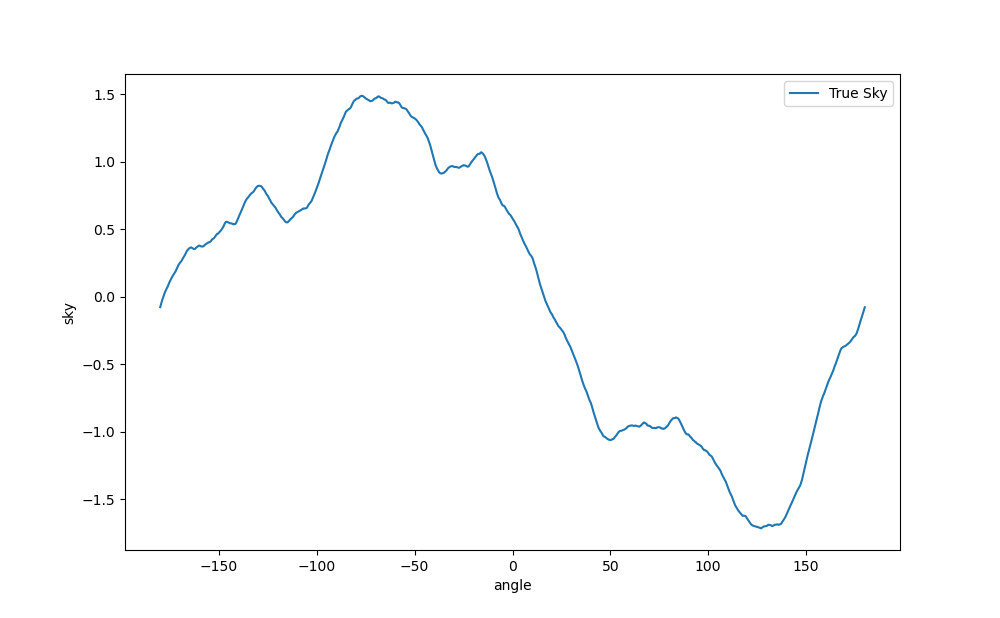

In [27]:
# Number of pointings, pixels, and detectors
nptg = params["npointings"]  # Time steps
npix = params["npix"]  # Pixels in the sky map
ndet = len(params["detpos"])  # Number of detectors

# Generate the input sky
params['plot_sky'] = True
xpix, truey = q1d.create_sky(params)

### Synthesized beam

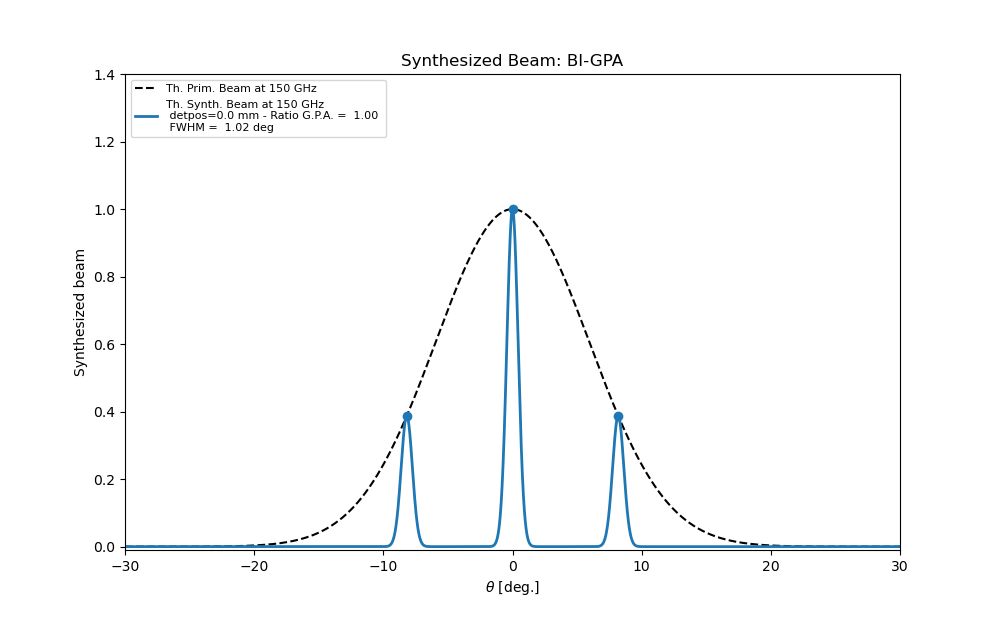

In [28]:
# Compute the synthesized beam properties
th = np.linspace(-params["minmaxtheta"], params["minmaxtheta"], params["ntheta"])
params['plot_sb'] = True
b, fwhmpeak, thetapeaks, amppeaks, ratio = q1d.prepare_synthesized_beam(th, params)

# Define reconstructed sky pixels grid and theoretical predictions

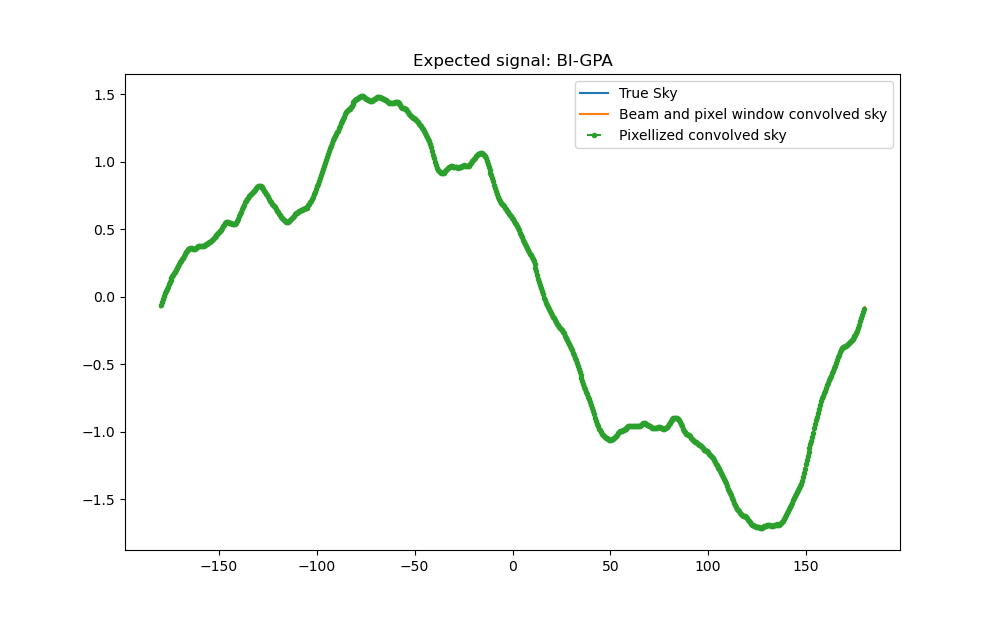

In [29]:
### We use the pixel window and resolution convolved sky as an input
params["sky_input"] == "BWconv"


# Define reconstructed sky pixel grid
pixels = np.linspace(-180, 180, params["npix"] + 1)
pix_center = 0.5 * (pixels[:-1] + pixels[1:])  # Compute pixel centers
dpix = pix_center[1] - pix_center[0]  # Pixel width

# Compute theoretical predictions for the reconstructed sky
bgauss = np.exp(-0.5 * (th / (fwhmpeak / np.sqrt(8 * np.log(2)))) ** 2)
Bconvy = q1d.conv_circ(truey, q1d.norm_filt(xpix, th, bgauss))
Bconvy_pix = np.interp(pix_center, xpix, Bconvy)  # Interpolate at pixel centers

if params["sky_input"] == "Bconv":
    Ctruth, Ctruth_pix = Bconvy, Bconvy_pix
elif params["sky_input"] == "BWconv":
    BWconvy = q1d.convolve_fourier_with_rectangular(Bconvy, dpix, xpix[1] - xpix[0])
    BWconvy_pix = np.interp(pix_center, xpix, BWconvy)
    Ctruth, Ctruth_pix = BWconvy, BWconvy_pix
else:
    raise ValueError("Incorrect <sky_input> in parameters")

# Plot expected signal
plt.figure()
plt.title("Expected signal: " + params["instrument_type"])
plt.plot(xpix, truey, label="True Sky")
plt.plot(xpix, Ctruth, label="Beam and pixel window convolved sky")
plt.errorbar(pix_center, Ctruth_pix, xerr=dpix / 2, fmt=".", label="Pixellized convolved sky")
plt.legend()


### Pointing

Text(0.5, 1.0, 'Pointings')

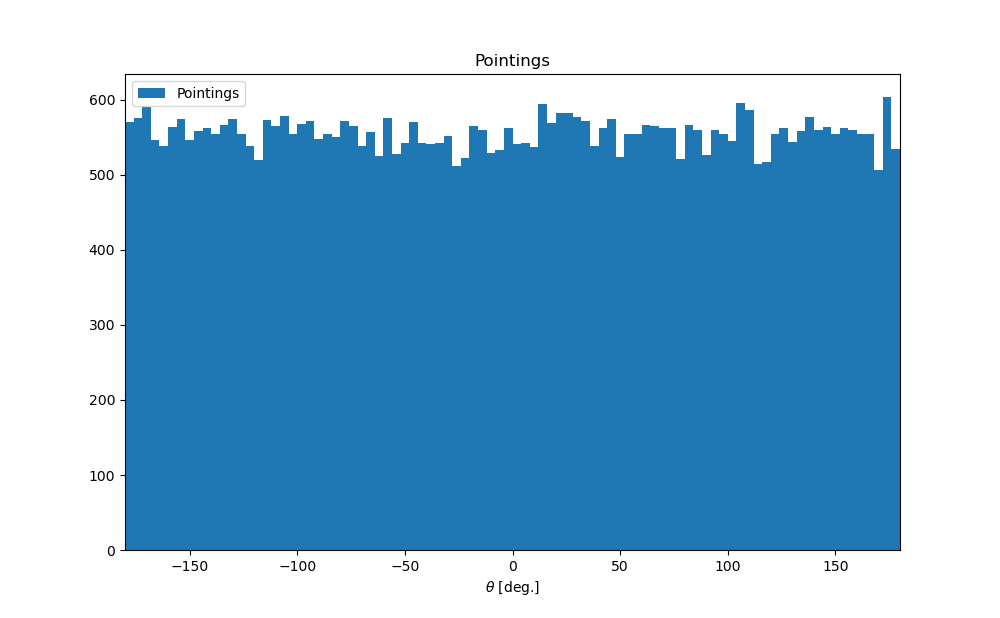

In [30]:
# Generate random pointing directions
np.random.seed(params["pointing_seed"])
ptg_deg = np.random.random(nptg) * 360 - 180

# Plot histogram of pointings if required
plt.figure()
plt.hist(ptg_deg, range=[-180, 180], bins=90, label="Pointings")
plt.xlim(-180, 180)
plt.legend()
plt.xlabel(r"$\theta$ [deg.]")
plt.title("Pointings")


### Generate TODs

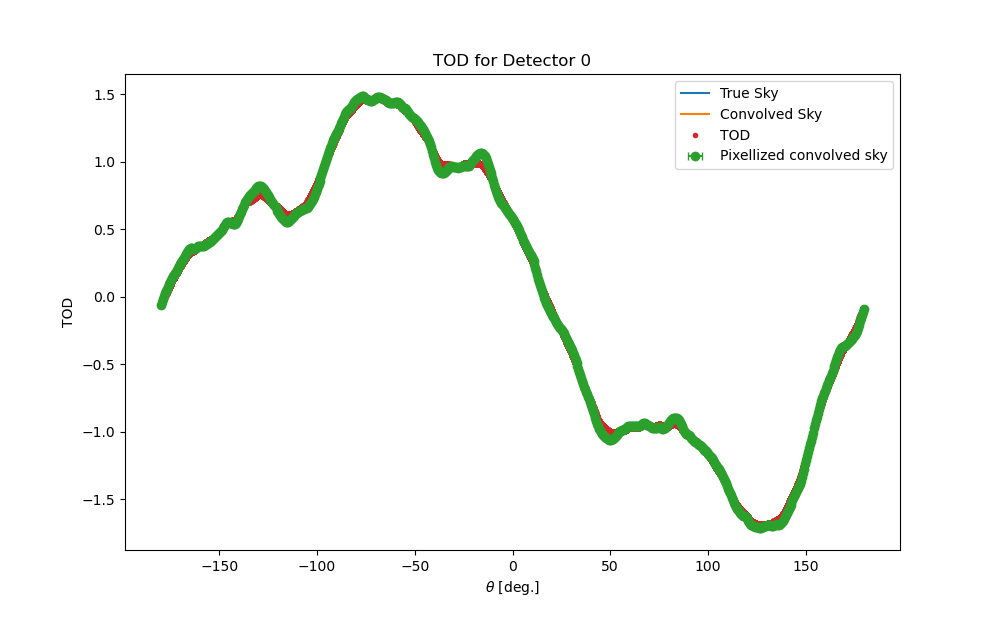

In [37]:
# Generate Time-Ordered Data (TOD)
reload(q1d)
params['TOD_method'] = 'approx'
params['plot_TOD'] = True   
TOD, sky_convolved, sky_convolved_pix, _ = q1d.build_TOD(params, [xpix, truey], ptg_deg, pix_center, algo=params["TOD_method"])

### H operator

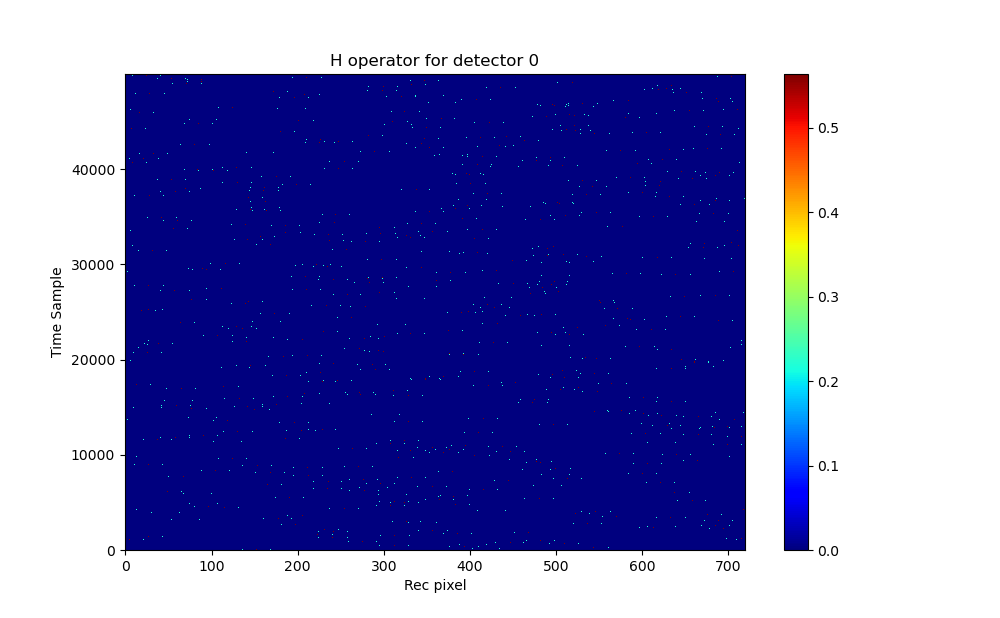

In [32]:
# Compute H operator
H = q1d.get_H_operator(params, th, ptg_deg)

numdet = 0

plt.figure()
plt.imshow(H[0], aspect="auto", interpolation="nearest", origin='lower')
plt.xlabel("Rec pixel")
plt.ylabel("Time Sample")
plt.title("H operator for detector {}".format(numdet))
plt.colorbar()

### Compute $H^t\cdot H$, its inverse and the solution

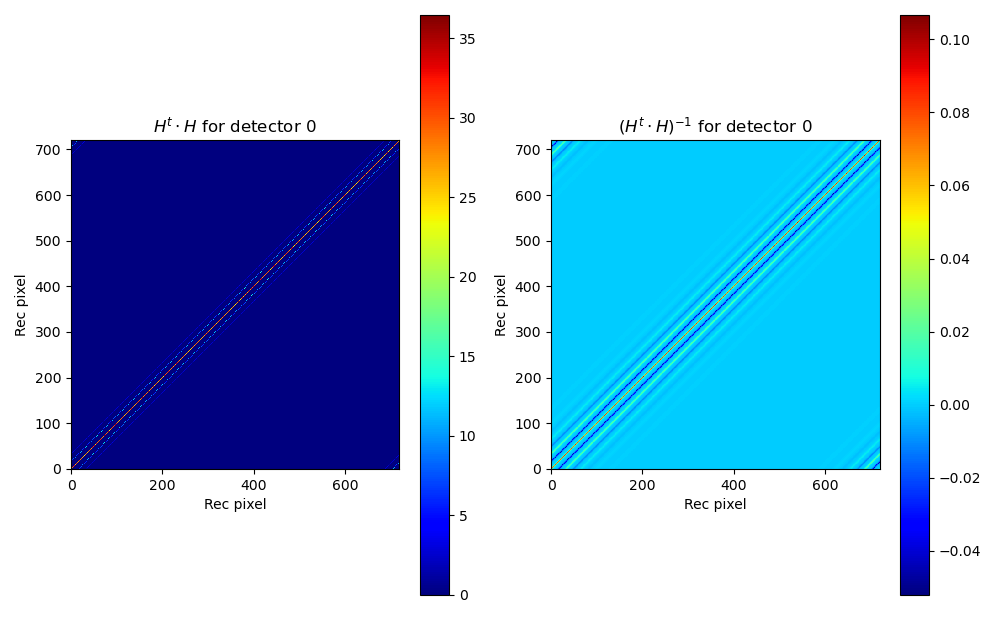

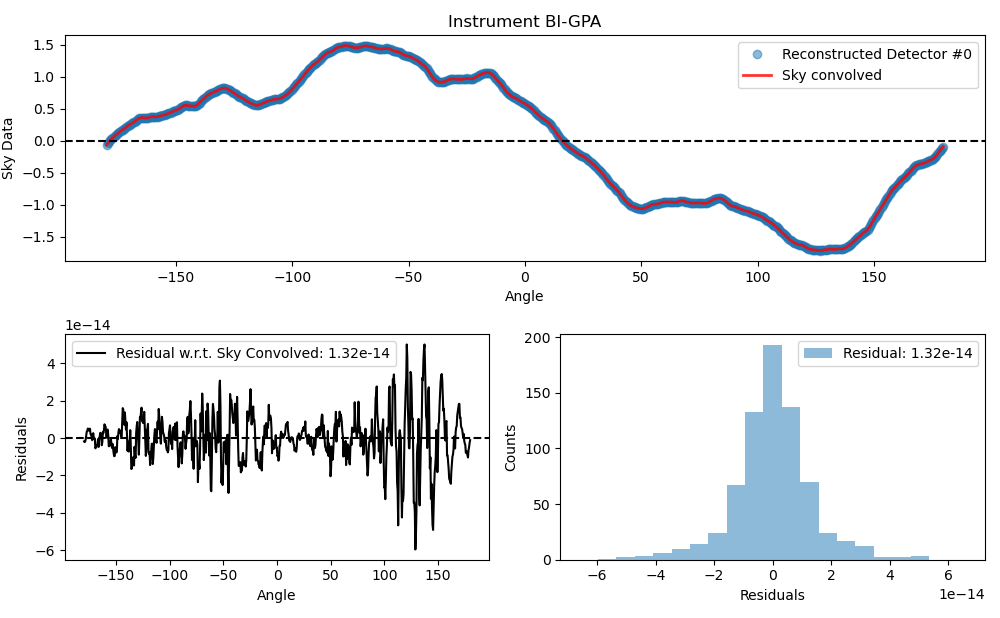

In [33]:
# Compute inverse covariance matrix and reconstruct sky map
HtH = np.zeros((ndet, npix, npix))
HtHinv = np.zeros((ndet, npix, npix))
solution = np.zeros((ndet, npix))

for i in range(ndet):
    HtH[i] = np.dot(H[i].T, H[i])
    HtHinv[i] = np.linalg.inv(HtH[i])
    solution[i] = np.dot(HtHinv[i], np.dot(H[i].T, TOD[i]))

# Compute average solution across detectors
solution_all = np.mean(solution, axis=0)

# Compute residuals
res_all = solution_all - Ctruth_pix
ss_all = np.std(res_all)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(HtH[0,:,:], aspect="equal", interpolation="nearest", origin='lower')
plt.xlabel("Rec pixel")
plt.ylabel("Rec pixel")
plt.title("$H^t\cdot H$ for detector {}".format(numdet))
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(HtHinv[0,:,:], aspect="equal", interpolation="nearest", origin='lower')
plt.xlabel("Rec pixel")
plt.ylabel("Rec pixel")
plt.title("$(H^t\cdot H)^{-1}$"+" for detector {}".format(numdet))
plt.colorbar()
plt.tight_layout()

plt.figure()
plt.subplot(2, 1, 1)
for i in range(ndet):
    plt.plot(pix_center, solution[i], "o", alpha=0.5, label=f"Reconstructed Detector #{i}")
plt.plot(pix_center, Ctruth_pix, lw=2, color="r", alpha=0.8, label="Sky convolved")
plt.legend()
plt.axhline(y=0, ls="--", color="k")
plt.xlabel("Angle")
plt.ylabel("Sky Data")
plt.title(f"Instrument {params['instrument_type']}")

plt.subplot(2, 2, 3)
plt.plot(pix_center, res_all, "k-", label=f"Residual w.r.t. Sky Convolved: {ss_all:.3g}")
plt.axhline(y=0, ls="--", color="k")
plt.xlabel("Angle")
plt.ylabel("Residuals")
plt.legend()

plt.subplot(2, 2, 4)
plt.hist(res_all, bins=21, range=[-5 * ss_all, 5 * ss_all], alpha=0.5, label=f"Residual: {ss_all:.3g}")
plt.xlabel("Residuals")
plt.ylabel("Counts")
plt.legend()
plt.tight_layout()

## Full simulation in a row
One can directly run everything and reconver the data using the following:

Residual w.r.t. Sky Convolved - All dets: 1.21e-14


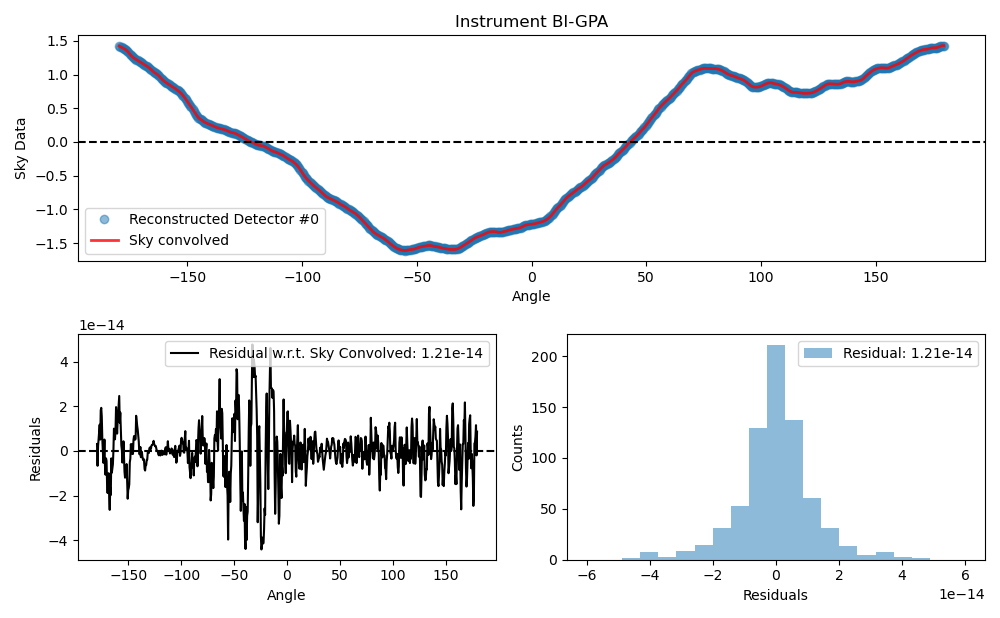

In [34]:
reload(q1d)
#### Reconstruct one
params = q1d.params.copy()
params['plot_sky']           = False
params['plot_sb']            = False
params['plot_expected']      = False
params['plot_pointings']     = False
params['plot_TOD']           = False
params['plot_reconstructed'] = True

### Sky model   
params['sky_input'] = 'BWconv'   # can be 'Bconv' or 'BWconv' in the first, we do not convolve the sky with the rec pixel window function

### Instrument
params['instrument_type'] = 'BI-GPA'

### TOD realism
params['TOD_method'] = 'approx'

### Noise level
params['noise_rms'] = 0.

### Seeds
params['sky_seed']           = None                    # Seed for the sky simulation
params['pointing_seed']      = None                    # Seed for the pointing
params['noise_seed']         = None                 # Seed for the noise

results = q1d.run_1d_simulation(params)
print(f"Residual w.r.t. Sky Convolved - All dets: {results['RMS_resall']:.3g}")

## Small Monte-Carlo simulation
We can now easily perform a Monte-Carlo simulation in order to investgate various effects.

In [35]:
#### FFT Analysis
params['sky_input'] = 'BWconv'   # can be 'Bconv' or 'BWconv' in the first, we do not convolve the sky with the rec pixel window function
params['instrument_type'] = 'BI-GPA'
params['TOD_method'] = 'approx'
params['sky_seed']           = None                    # Seed for the sky simulation
params['pointing_seed']      = None                    # Seed for the pointing
params['noise_seed']         = None                 # Seed for the noise
params['plot_sb']            = False
params['plot_reconstructed'] = False

nn = 30
plotall = False

all_ps_sky = np.zeros((nn, params['npix_sky']))
all_ps_sky_pix = np.zeros((nn, params['npix']))
all_ps_solution = np.zeros((nn, params['npix']))


for i in range(nn):
    results = q1d.run_1d_simulation(params)
    print(i, results['RMS_resall'])
    
    freq_pix = np.abs(np.fft.fftfreq(len(results['pix_center']), d=results['pix_center'][1]-results['pix_center'][0]))
    all_ps_sky_pix[i,:] = np.abs(np.fft.fft(results['Ctruth_pix']))**2 / len(results['Ctruth_pix'])**2
    all_ps_solution[i,:] = np.abs(np.fft.fft(results['solution_all']))**2  / len(results['Ctruth_pix']) **2

    freq_sky = np.abs(np.fft.fftfreq(len(results['xpix']), d=results['xpix'][1]-results['xpix'][0]))
    all_ps_sky[i,:] = np.abs(np.fft.fft(results['truey']))**2 / len(results['xpix'])**2
    
    if plotall:
        plt.figure()
        plt.subplot(2,1,1)
        plt.plot(freq_sky, all_ps_sky[i,:], label='Input Sky', alpha=0.3)
        plt.plot(freq_pix, all_ps_sky_pix[i,:], alpha=0.5, label='Expected Pixelized Sky')
        plt.plot(freq_pix, all_ps_solution[i,:], 'x', alpha=0.5, label='Solution')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Freq [$deg^{-1}$]')
        plt.ylabel('Power Spectrum')
        plt.ylim(1e-15, 1e0)
        plt.legend()
        
        plt.subplot(2,1,2)
        plt.plot(freq_pix, ps_solution / ps_sky_pix, label='Transfer fuction')
        plt.axhline(y=1, ls=':', color='k')
        plt.xscale('log')
        plt.xlabel('Freq [$deg^{-1}$]')
        plt.ylabel('Power Spectrum')
        plt.ylim(0.7,1.5)
        plt.legend()
        plt.tight_layout()



0 1.1293174028960698e-14
1 1.0041265613861892e-14
2 9.989339661615997e-15
3 1.2343572109604662e-14
4 1.0095435556234007e-14
5 1.0781291620914826e-14
6 1.0043421963675107e-14
7 1.1557861619009145e-14
8 1.2535411753881854e-14
9 8.296298287458384e-15
10 9.983320016477708e-15
11 9.491362841292549e-15
12 1.1034475512114428e-14
13 1.0113145692920873e-14
14 1.3599753431781016e-14
15 8.710681420417964e-15
16 1.128794006852239e-14
17 1.341200887314924e-14
18 1.4112513904570723e-14
19 1.2044190606128952e-14
20 1.4057905560491882e-14
21 1.052854041537898e-14
22 1.0284530071990749e-14
23 1.3895110798473153e-14
24 1.1976698682677488e-14
25 1.0361302660661708e-14
26 9.379187732516575e-15
27 1.1462859284767237e-14
28 9.798767646554845e-15
29 1.3535744083635086e-14


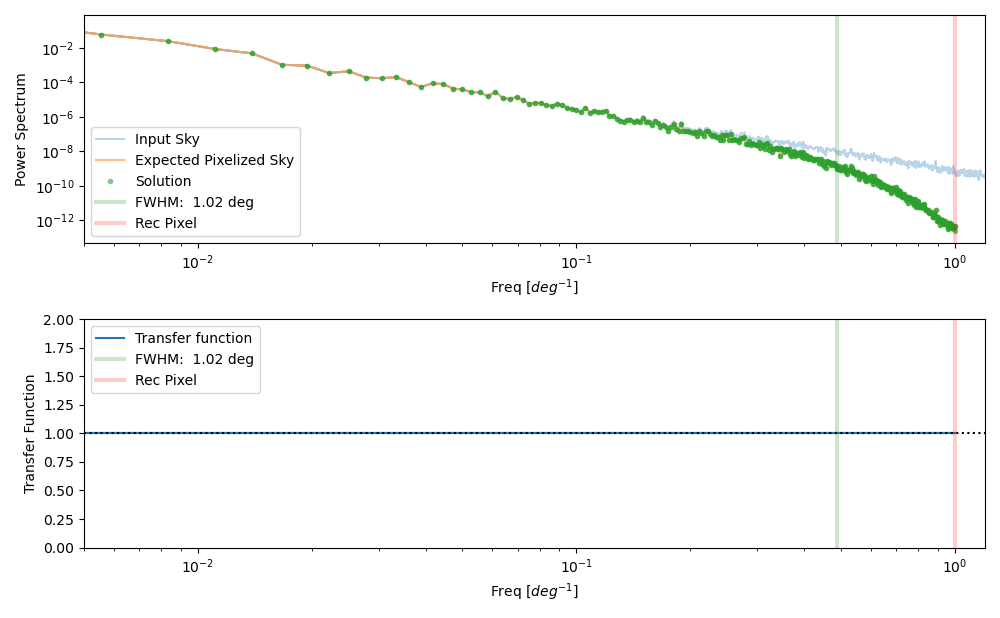

In [36]:
#### Power spectrum analysis

fwhmpeaks = results['beam_params'][0]
amppeaks = results['beam_params'][1]
thetapeaks = results['beam_params'][2]


known_freqs = []
known_freqs.append({'label':'FWHM: {0:5.3g} deg'.format(fwhmpeaks), 'freq': 1./(fwhmpeaks)/2, 'color':'g', 'ls':'-', 'lw': 3, 'nbharm': 1})
known_freqs.append({'label':'Rec Pixel', 'freq': 1./(results['pix_center'][1]-results['pix_center'][0])/2, 'color':'r', 'ls':'-', 'lw': 3, 'nbharm': 1 })

# ftest = 1./params['fwhmprim_150']
# mylabel = 'Primary beam'


aa = 0.2
harm_max=50

plt.figure()
plt.subplot(2,1,1)
plt.plot(freq_sky, np.mean(all_ps_sky, axis=0), label='Input Sky', alpha=0.3)
plt.plot(freq_pix, np.mean(all_ps_sky_pix, axis=0), alpha=0.5, label='Expected Pixelized Sky')
plt.plot(freq_pix, np.mean(all_ps_solution, axis=0), '.', alpha=0.5, label='Solution')
for fff in known_freqs:
    p=plt.axvline(x = fff['freq'], ls=fff['ls'], lw=fff['lw'], alpha=aa, label=fff['label'], color=fff['color'])
    for i in range(2,fff['nbharm']):
        plt.axvline(x = i * fff['freq'], ls=fff['ls'], lw=fff['lw'], color=fff['color'], alpha=aa)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [$deg^{-1}$]')
plt.ylabel('Power Spectrum')
plt.xlim(5e-3, np.max(freq_pix)*1.2)
plt.ylim(np.min(np.mean(all_ps_solution, axis=0))/5, np.max(np.mean(all_ps_solution, axis=0))*2)
plt.legend()

plt.subplot(2,1,2)
plt.plot(freq_pix, np.mean(all_ps_solution, axis=0) / np.mean(all_ps_sky_pix, axis=0), label='Transfer function')
plt.axhline(y=1, ls=':', color='k')
for fff in known_freqs:
    p=plt.axvline(x = fff['freq'], ls=fff['ls'], lw=fff['lw'], alpha=aa, label=fff['label'], color=fff['color'])
    for i in range(2,fff['nbharm']):
        plt.axvline(x = i * fff['freq'], ls=fff['ls'], lw=fff['lw'], color=fff['color'], alpha=aa)
plt.xscale('log')
plt.xlabel('Freq [$deg^{-1}$]')
plt.ylabel('Transfer Function')
plt.ylim(0.,2.)
plt.xlim(5e-3, np.max(freq_pix)*1.2)
plt.legend()
plt.tight_layout()
